In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import numpy as np
from torch.utils.data import Dataset, DataLoader
import json
import os
import glob
from geopy.geocoders import Nominatim
import re
import pandas as pd
from torchvision.io import read_image
from sklearn.preprocessing import LabelEncoder
from torch.utils.tensorboard import SummaryWriter
import sklearn
from torchvision.transforms import InterpolationMode
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit
import sklearn
import math
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True 
from munkres import Munkres

In [2]:
from pathlib import Path
import argparse
import json
import os
import random
import signal
import sys
import time
import urllib

from torch import nn, optim
from torchvision import datasets, transforms
import torch
torch.cuda.empty_cache()

import resnet

import numpy as np
from PIL import Image
import numpy as np
from torch.utils.data import Dataset, DataLoader
import json

import glob
from geopy.geocoders import Nominatim
import re
import pandas as pd
from torchvision.io import read_image
from sklearn.preprocessing import LabelEncoder
from torch.utils.tensorboard import SummaryWriter
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit
import math
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True   #OTHERWISE TRUNCATED IMAGE FILE ERROR SOMEWHERE IN ENUMERATE(DATALOADER)!!!!

import resnet

import torchvision

In [3]:
def get_y_preds(cluster_assignments, y_true, n_clusters):
    '''
    Computes the predicted labels, where label assignments now
    correspond to the actual labels in y_true (as estimated by Munkres)

    cluster_assignments:    array of labels, outputted by kmeans
    y_true:                 true labels
    n_clusters:             number of clusters in the dataset

    returns:    a tuple containing the accuracy and confusion matrix,
                in that order
    '''
    confusion_matrix = sklearn.metrics.confusion_matrix(y_true, cluster_assignments, labels=None)
    # compute accuracy based on optimal 1:1 assignment of clusters to labels
    cost_matrix = calculate_cost_matrix(confusion_matrix, n_clusters)
    indices = Munkres().compute(cost_matrix)
    kmeans_to_true_cluster_labels = get_cluster_labels_from_indices(indices)
    y_pred = kmeans_to_true_cluster_labels[cluster_assignments]
    return y_pred, confusion_matrix 

def calculate_cost_matrix(C, n_clusters):
    cost_matrix = np.zeros((n_clusters, n_clusters))

    # cost_matrix[i,j] will be the cost of assigning cluster i to label j
    for j in range(n_clusters):
        s = np.sum(C[:,j]) # number of examples in cluster i
        for i in range(n_clusters):
            t = C[i,j]
            cost_matrix[j,i] = s-t
    return cost_matrix

def get_cluster_labels_from_indices(indices):
    n_clusters = len(indices)
    clusterLabels = np.zeros(n_clusters)
    for i in range(n_clusters):
        clusterLabels[i] = indices[i][1]
    return clusterLabels

In [4]:
truth = np.array([0,0,0,1,1,1,2,2,2,3,3,3])
pred=np.array([1,1,1,1,3,3,2,2,2,2,0,0])
print(np.sum( get_y_preds(pred, truth, 4)[0] == truth )/len(truth) )

0.8333333333333334


In [5]:
batch_size = 1

In [6]:
class SN7Dataset(Dataset):
    
    def __init__(self, transform=None, train=True):
        
        if train == True:
            self.img_ids_labels = pd.read_csv("../../ids_and_labels_test_seen_filtered.csv", header = None) 
        else:
            self.img_ids_labels = pd.read_csv("../../ids_and_labels_test_unseen_filtered.csv", header = None)
            
        self.img_dir = '/local/home/stuff/datasets/Challenge_7/test_public'
        self.transform = transform
        
    def __getitem__(self, idx):
        #print(self.img_ids_labels.iloc[idx, 0])
        image_id, patch_id = self.img_ids_labels.iloc[idx, 0].split("!")[1],self.img_ids_labels.iloc[idx, 0].split("!")[0]
        pattern = "mosaic_(.*?).tif"
        location_id = re.search(pattern, image_id).group(1)
        #print(image_id)
        #print(location_id)
        img_path = os.path.join(self.img_dir, location_id, 'images_masked', image_id )
        image = torchvision.transforms.ToTensor()(Image.open(img_path))[0:3,:,:]  #TAKE RGB CHANNELS ONLY FOR RESNET COMPATIBILITY!!!
        
        image_padded = torch.nn.functional.pad(image, pad=(0, 1024 - image.shape[2], 0, 1024 - image.shape[1]))
        patches = image_padded.unfold(1, 256, 256).unfold(2, 256, 256)
        patches = patches.reshape(3, -1, 256, 256)
        patches = patches.permute(1,0,2,3)
        
        image = patches[int(patch_id)]
        
        label = torch.from_numpy(np.asarray(self.img_ids_labels.iloc[idx, 1])).type(torch.LongTensor)
        
        #patches = patches.view(-1, 3, 256, 256)
        #print(patches.shape)
        #label = label.flatten()
        #label = label.type(torch.LongTensor)
        
        
        image = self.transform(image)
                
            
        #if self.target_transform:
            #label = self.target_transform(label)
            
        
        return image, label
        
    def __len__(self):
        
        return len(self.img_ids_labels)

In [8]:
#transform = transforms.Compose([ transforms.Resize(224), transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]) ])

normalize = torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

seen_transforms = transforms.Compose(
            [   
                transforms.RandomResizedCrop(224*2),
                transforms.RandomHorizontalFlip(),
                transforms.Resize(224),
                normalize,
            ]
        )

unseen_transforms = transforms.Compose(
            [
                transforms.CenterCrop(224*2),
                transforms.Resize(224),
                normalize,
            ]
        )

test_seen_dataset = SN7Dataset(train=True, transform = seen_transforms)
test_unseen_dataset = SN7Dataset(train=False, transform = unseen_transforms)

test_seen_loader = DataLoader(dataset=test_seen_dataset, batch_size = batch_size, shuffle = False)
test_unseen_loader = DataLoader(dataset=test_unseen_dataset, batch_size = batch_size, shuffle = False)

In [9]:
#device = torch.device("cpu")

In [10]:
torch.cuda.current_device()
torch.cuda.set_device(0)
print(torch.cuda.mem_get_info(torch.cuda.current_device()))
device = torch.cuda.current_device()

(12268863488, 12806062080)


In [11]:
backbone, embedding = resnet.__dict__['resnet50'](zero_init_residual=True)
#state_dict = torch.load('exp/resnet18_3.pth', map_location="cpu")
#state_dict = torch.load('exp/resnet18_new_4096_200.pth', map_location="cpu")
#state_dict = torch.load('exp/resnet18_100_newest.pth', map_location="cpu")
#state_dict = torch.load('exp/resnet50_100epochs_16_factor.pth', map_location="cpu")
#state_dict = torch.load('exp/vicreg_temporal_200.pth', map_location="cpu")
state_dict = torch.load('exp/resnet50_vicreg_sn7_temporal_100.pth')
if "model" in state_dict:
    state_dict = state_dict["model"]
    state_dict = {key.replace("module.backbone.", ""): value for (key, value) in state_dict.items()}
backbone.load_state_dict(state_dict, strict=False)
backbone.to(device)

ResNet(
  (padding): ConstantPad2d(padding=(1, 1, 1, 1), value=0.0)
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(2, 2), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(


In [12]:
print(embedding)
backbone.eval()

2048


ResNet(
  (padding): ConstantPad2d(padding=(1, 1, 1, 1), value=0.0)
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(2, 2), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(


In [13]:
labels_list = []
embeddings_list = []

with torch.no_grad():
    
    for i, (inputs, labels) in enumerate(test_seen_loader):
        if i%500 == 0:
            print(i)
        embedding = backbone(inputs.to(device))
        embeddings_list.append(embedding)
        labels_list.append(labels)

    


0
500
1000
1500
2000
2500
3000
3500
4000
4500
5000


In [14]:
embeddings_seen_arr = np.zeros((len(test_seen_loader), 2048))
counter = 0
for embedding in embeddings_list:
    embeddings_seen_arr[counter,:] = embedding.cpu().detach().numpy()
    counter += 1
#embeddings_unseen_arr = torch.tensor(embeddings_unseen_list)
#labels_unseen_arr = np.array(labels_unseen_list)

print(embeddings_seen_arr)
print(embeddings_seen_arr.shape)
labels_seen_arr = np.zeros(len(test_seen_loader))
counter = 0
for i in labels_list:
    labels_seen_arr[counter] = i.detach().numpy()
    counter += 1
print(labels_seen_arr)

#np.savetxt("seen_embeddings.csv", embeddings_seen_arr, delimiter=",", fmt='%s')

[[0.         0.00857346 0.00029341 ... 0.17416611 0.00110524 0.03885284]
 [0.         0.00692075 0.         ... 0.17349412 0.         0.00456782]
 [0.00044608 0.01096863 0.         ... 0.1731071  0.00179152 0.00640594]
 ...
 [0.         0.02168793 0.00690746 ... 0.17354272 0.00537809 0.00802893]
 [0.00238838 0.05740981 0.00048004 ... 0.17176592 0.         0.00277365]
 [0.02639676 0.04556495 0.00255554 ... 0.17249967 0.00270077 0.01548615]]
(5462, 2048)
[ 3.  3.  3. ... 15. 15. 15.]


In [15]:
labels_unseen_list = []
embeddings_unseen_list = []

with torch.no_grad():
    
    for i, (inputs, labels) in enumerate(test_unseen_loader):
        if i%500 == 0:
            print(i)
        embedding = backbone(inputs.to(device))
        embeddings_unseen_list.append(embedding)
        labels_unseen_list.append(labels)
    

0
500
1000
1500


In [16]:
embeddings_unseen_arr = np.zeros((len(test_unseen_loader), 2048))
counter = 0
for embedding in embeddings_unseen_list:
    embeddings_unseen_arr[counter,:] = embedding.cpu().detach().numpy()
    counter += 1
#embeddings_unseen_arr = torch.tensor(embeddings_unseen_list)
#labels_unseen_arr = np.array(labels_unseen_list)

In [17]:
print(embeddings_unseen_arr)
print(embeddings_unseen_arr.shape)
labels_unseen_arr = np.zeros(len(test_unseen_loader))
counter = 0
for i in labels_unseen_list:
    labels_unseen_arr[counter] = i.detach().numpy()
    counter += 1
print(labels_unseen_arr)

#np.savetxt("unseen_embeddings.csv", embeddings_unseen_arr, delimiter=",", fmt='%s')
    

[[2.28518490e-02 1.48858363e-02 1.27195679e-02 ... 1.72414005e-01
  0.00000000e+00 0.00000000e+00]
 [9.59772337e-03 2.91682519e-02 0.00000000e+00 ... 1.71554983e-01
  8.97438964e-04 2.24873729e-04]
 [1.95676490e-04 7.15099648e-03 1.05394805e-02 ... 1.72157153e-01
  5.45106595e-05 1.84925776e-02]
 ...
 [5.00593567e-04 1.96976978e-02 8.14152649e-04 ... 1.71524361e-01
  2.08570785e-03 8.78756586e-03]
 [0.00000000e+00 4.48942482e-02 3.47150001e-03 ... 1.71926260e-01
  7.67351157e-05 1.77654941e-02]
 [0.00000000e+00 5.49093448e-03 0.00000000e+00 ... 1.72302321e-01
  0.00000000e+00 1.33847271e-03]]
(1794, 2048)
[19. 19. 19. ... 16. 16. 16.]


In [18]:
#embeddings_seen_arr = torch.nn.functional.normalize(torch.Tensor(embeddings_seen_arr), dim=1, p=2)
#embeddings_unseen_arr = torch.nn.functional.normalize(torch.Tensor(embeddings_unseen_arr), dim=1, p=2)

[ 0.  2. 14. 19.]


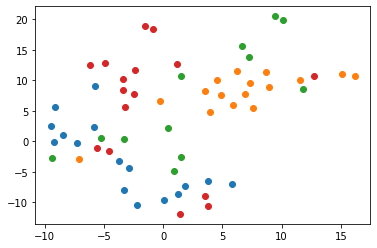

In [19]:
#JUST TRY DELETE LATER

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

embeddings_unseen_arr_trial = embeddings_unseen_arr[0:60,:]
labels_unseen_arr_trial = labels_unseen_arr[0:60]

#pca = PCA(n_components=2)
#pca.fit(embeddings_unseen_arr)
#print(pca.explained_variance_ratio_)

#embeddings_reduced = pca.transform(embeddings_unseen_arr)
#print(embeddings_reduced)

u_labels = np.unique(labels_unseen_arr_trial)
print(u_labels)

embeddings_reduced = TSNE(n_components=2, learning_rate='auto',init='random', perplexity = 10.0).fit_transform(embeddings_unseen_arr_trial)

for i in u_labels:
    
    plt.scatter(embeddings_reduced[labels_unseen_arr_trial == i , 0] , embeddings_reduced[labels_unseen_arr_trial == i , 1] , label = i)

#plt.legend()
plt.show()

In [20]:
from sklearn.neighbors import KNeighborsClassifier

n_neighbours = [1, 3, 5, 10, 20, 30, 40, 50, 200]

for k in n_neighbours:
    
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(embeddings_seen_arr, labels_seen_arr)
    labels_predicted = knn.predict(embeddings_unseen_arr)

    #print('Accuracy' + str(k) + ':', np.sum(labels_unseen_arr == labels_predicted)/len(labels_unseen_arr))
    print('Accuracy:', knn.score(embeddings_unseen_arr, labels_unseen_arr))

Accuracy: 0.07190635451505016
Accuracy: 0.028428093645484948
Accuracy: 0.024526198439241916
Accuracy: 0.08974358974358974
Accuracy: 0.0641025641025641
Accuracy: 0.0758082497212932
Accuracy: 0.07859531772575251
Accuracy: 0.06967670011148272
Accuracy: 0.05406911928651059


In [21]:
from sklearn.cluster import AgglomerativeClustering

#labels_predicted = AgglomerativeClustering(n_clusters = 20).fit_predict(embeddings_unseen_arr)

#truth = labels_unseen_arr
#pred = labels_predicted
#print('Accuracy Afteer Hungarian Assignment:',np.sum( get_y_preds(pred, truth, 20)[0] == truth )/len(truth) )

#print(sklearn.metrics.rand_score(labels_unseen_arr, labels_predicted))

whole_test_set = np.concatenate((embeddings_seen_arr,embeddings_unseen_arr), axis=0)
whole_labels = np.concatenate((labels_seen_arr, labels_unseen_arr))

labels_predicted = AgglomerativeClustering(n_clusters = 20).fit_predict(whole_test_set)

truth = whole_labels
pred = labels_predicted
print('Accuracy Afteer Hungarian Assignment:',np.sum( get_y_preds(pred, truth, 20)[0] == truth )/len(truth) )

Accuracy Afteer Hungarian Assignment: 0.15669790518191842


In [22]:
from sklearn.cluster import KMeans

#kmeans = KMeans(n_clusters=20, random_state=36).fit(embeddings_seen_arr)
#labels_predicted = kmeans.predict(embeddings_unseen_arr)
#print(labels_predicted.shape)

#truth = labels_unseen_arr
#pred = labels_predicted
#print('Accuracy Afteer Hungarian Assignment:',np.sum( get_y_preds(pred, truth, 20)[0] == truth )/len(truth) )

kmeans = KMeans(n_clusters=20, random_state=36).fit(whole_test_set)
labels_predicted = kmeans.predict(whole_test_set)
print(whole_labels.shape)

truth = whole_labels
pred = labels_predicted
print('Accuracy Afteer Hungarian Assignment:',np.sum( get_y_preds(pred, truth, 20)[0] == truth )/len(truth) )



(7256,)
Accuracy Afteer Hungarian Assignment: 0.17861080485115766


In [23]:
#normalize = torchvision.transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
normalize = torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

seen_transforms = transforms.Compose(
            [   
                #transforms.RandomResizedCrop(224),
                #transforms.RandomHorizontalFlip(),
                transforms.Resize(224),
                normalize,
            ]
        )

unseen_transforms = transforms.Compose(
            [
                #transforms.CenterCrop(224),
                transforms.Resize(224),
                normalize,
            ]
        )

test_seen_dataset = SN7Dataset(train=True, transform = seen_transforms)
test_unseen_dataset = SN7Dataset(train=False, transform = unseen_transforms)

test_seen_loader = DataLoader(dataset=test_seen_dataset, batch_size = batch_size, shuffle = False)
test_unseen_loader = DataLoader(dataset=test_unseen_dataset, batch_size = batch_size, shuffle = False)

In [26]:
#####FOR SUPERVİSED MODEL!!!!

backbone_supervised, embedding = resnet.__dict__['resnet50'](zero_init_residual=True)
#state_dict = torch.load('../../Supervised_Model.pth', map_location="cpu")
state_dict = torch.load('../../Supervised_Model_Resnet50_Scheduler_3.pth', map_location="cpu")
if "model" in state_dict:
    state_dict = state_dict["model"]
    state_dict = {key.replace("module.backbone.", ""): value for (key, value) in state_dict.items()}
backbone_supervised.load_state_dict(state_dict, strict=False)
backbone_supervised.to(device)

ResNet(
  (padding): ConstantPad2d(padding=(1, 1, 1, 1), value=0.0)
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(2, 2), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(


In [27]:
print(embedding)
backbone_supervised.eval()

2048


ResNet(
  (padding): ConstantPad2d(padding=(1, 1, 1, 1), value=0.0)
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(2, 2), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(


In [28]:
labels_list_supervised = []
embeddings_list_supervised = []

with torch.no_grad():
    
    for i, (inputs, labels) in enumerate(test_seen_loader):
        if i%500 == 0:
            print(i)
        embedding = backbone_supervised(inputs.to(device))
        embeddings_list_supervised.append(embedding)
        labels_list_supervised.append(labels)

0
500
1000
1500
2000
2500
3000
3500
4000
4500
5000


In [29]:
embeddings_seen_arr_supervised = np.zeros((len(test_seen_loader), 2048))
counter = 0
for embedding in embeddings_list_supervised:
    embeddings_seen_arr_supervised[counter,:] = embedding.cpu().detach().numpy()
    counter += 1
#embeddings_unseen_arr = torch.tensor(embeddings_unseen_list)
#labels_unseen_arr = np.array(labels_unseen_list)

print(embeddings_seen_arr_supervised)
labels_seen_arr_supervised = np.zeros(len(test_seen_loader))
counter = 0
for i in labels_list_supervised:
    labels_seen_arr_supervised[counter] = i.detach().numpy()
    counter += 1
print(labels_seen_arr_supervised)

[[0.84871197 1.26456547 1.12228572 ... 0.73571879 1.32406521 0.78814322]
 [0.87003964 1.28574622 1.35793114 ... 0.67702383 1.51662338 0.69465929]
 [0.62975729 0.9216783  1.01126254 ... 0.47731477 0.93834639 0.97716683]
 ...
 [0.83698577 0.98327917 1.39463353 ... 1.40380478 2.67151594 0.49266979]
 [0.88133848 1.18443727 1.2995981  ... 1.18306625 1.8353368  0.89126372]
 [0.75164145 1.36933672 1.42966413 ... 0.26392394 1.59773564 0.32518446]]
[ 3.  3.  3. ... 15. 15. 15.]


In [30]:
labels_unseen_list_supervised = []
embeddings_unseen_list_supervised = []

with torch.no_grad():
    
    for i, (inputs, labels) in enumerate(test_unseen_loader):
        if i%500 == 0:
            print(i)
        embedding = backbone_supervised(inputs.to(device))
        embeddings_unseen_list_supervised.append(embedding)
        labels_unseen_list_supervised.append(labels)

0
500
1000
1500


In [31]:
embeddings_unseen_arr_supervised = np.zeros((len(test_unseen_loader), 2048))
counter = 0
for embedding in embeddings_unseen_list_supervised:
    embeddings_unseen_arr_supervised[counter,:] = embedding.cpu().detach().numpy()
    counter += 1
#embeddings_unseen_arr = torch.tensor(embeddings_unseen_list)
#labels_unseen_arr = np.array(labels_unseen_list)

print(embeddings_unseen_arr_supervised)
labels_unseen_arr_supervised = np.zeros(len(test_unseen_loader))
counter = 0
for i in labels_unseen_list_supervised:
    labels_unseen_arr_supervised[counter] = i.detach().numpy()
    counter += 1
print(labels_unseen_arr_supervised)

[[1.21723342 1.07491875 0.66230059 ... 2.98844099 1.9248215  1.64361477]
 [1.39939094 0.90409064 1.03422797 ... 1.63007677 0.57481796 0.47210646]
 [0.05551666 1.59285748 1.34528863 ... 0.70756644 0.166495   0.63216615]
 ...
 [1.4558351  2.04253364 1.11305583 ... 0.68992674 0.27074087 0.555264  ]
 [1.34078383 1.40635931 1.26761782 ... 0.89385384 0.42966905 0.09774573]
 [0.82145923 2.0500412  1.66297555 ... 0.42889443 0.35865897 0.33730614]]
[19. 19. 19. ... 16. 16. 16.]


[ 0.  2. 14. 19.]


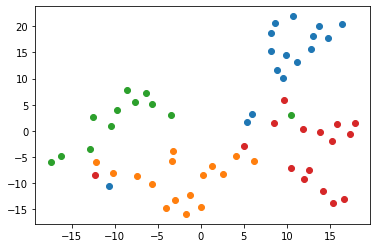

In [32]:
#JUST TRY DELETE LATER

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

embeddings_unseen_arr_trial = embeddings_unseen_arr_supervised[0:60,:]
labels_unseen_arr_trial = labels_unseen_arr_supervised[0:60]

#pca = PCA(n_components=2)
#pca.fit(embeddings_unseen_arr)
#print(pca.explained_variance_ratio_)

#embeddings_reduced = pca.transform(embeddings_unseen_arr)
#print(embeddings_reduced)

u_labels = np.unique(labels_unseen_arr_trial)
print(u_labels)

embeddings_reduced = TSNE(n_components=2, learning_rate='auto',init='random', perplexity = 10.0).fit_transform(embeddings_unseen_arr_trial)

for i in u_labels:
    
    plt.scatter(embeddings_reduced[labels_unseen_arr_trial == i , 0] , embeddings_reduced[labels_unseen_arr_trial == i , 1] , label = i)

#plt.legend()
plt.show()

In [33]:
from sklearn.neighbors import KNeighborsClassifier

n_neighbours = [1, 3, 5, 10, 20, 30, 40, 50, 200]

for k in n_neighbours:
    
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(embeddings_seen_arr_supervised, labels_seen_arr_supervised)
    labels_predicted = knn.predict(embeddings_unseen_arr_supervised)

    #print('Accuracy' + str(k) + ':', np.sum(labels_unseen_arr == labels_predicted)/len(labels_unseen_arr))
    print('Accuracy:', knn.score(embeddings_unseen_arr_supervised, labels_unseen_arr_supervised))

Accuracy: 0.7374581939799331
Accuracy: 0.7391304347826086
Accuracy: 0.7352285395763657
Accuracy: 0.7196209587513935
Accuracy: 0.6978818283166109
Accuracy: 0.6677814938684504
Accuracy: 0.6516164994425864
Accuracy: 0.6376811594202898
Accuracy: 0.5691192865105908


In [34]:
from sklearn.cluster import KMeans

print(embeddings_seen_arr_supervised.shape)
print(embeddings_unseen_arr_supervised.shape)

whole_test_set = np.concatenate((embeddings_seen_arr_supervised,embeddings_unseen_arr_supervised), axis=0)
whole_labels = np.concatenate((labels_seen_arr_supervised, labels_unseen_arr_supervised))

kmeans = KMeans(n_clusters=20, random_state=36).fit(whole_test_set)
labels_predicted = kmeans.predict(whole_test_set)
print(labels_predicted)

truth = whole_labels
pred = labels_predicted
print('Accuracy Afteer Hungarian Assignment:',np.sum( get_y_preds(pred, truth, 20)[0] == truth )/len(truth) )

(5462, 2048)
(1794, 2048)
[15 15 15 ... 14  8  8]
Accuracy Afteer Hungarian Assignment: 0.3807883131201764


In [ ]:
import faiss

class FaissKNeighbors:
    def __init__(self, k):
        self.index = None
        self.y = None
        self.k = k

    def fit(self, X, y):
        self.index = faiss.IndexFlatL2(X.shape[1])
        self.index.add(X.astype(np.float32))
        self.y = y

    def predict(self, X):
        distances, indices = self.index.search(X.astype(np.float32), k=self.k)
        votes = self.y[indices]
        predictions = np.array([np.argmax(np.bincount(x)) for x in votes.astype(np.int64)])
        return predictions

In [ ]:
train = np.array([[1,0]])
train_labels = np.array([0])

test = np.array([[0,0]])

knn = FaissKNeighbors(k=1)

knn.fit(train, train_labels)
label_predicted = knn.predict(test)
print(label_predicted)

new_data = np.array([[-0.5,0]])
new_label = np.array([1])

knn.fit(new_data, new_label)
label_predicted = knn.predict(test)
print(label_predicted)